<a href="https://colab.research.google.com/github/present42/PyTorchPractice/blob/main/PyTorch_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [ ]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Dutch.txt', 'data/names/Scottish.txt', 'data/names/Polish.txt', 'data/names/German.txt', 'data/names/Russian.txt', 'data/names/Arabic.txt', 'data/names/Irish.txt', 'data/names/Czech.txt', 'data/names/Korean.txt', 'data/names/Japanese.txt', 'data/names/Vietnamese.txt', 'data/names/Portuguese.txt', 'data/names/French.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/English.txt', 'data/names/Chinese.txt', 'data/names/Spanish.txt']


In [ ]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [ ]:
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

In [ ]:
# category_lines dictionary for a list of names per langauge
category_lines = {}
all_categories = []

def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

In [ ]:
for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

In [ ]:
n_categories = len(all_categories)

## Turning Names into Tensors

In [ ]:
import torch

def letterToIndex(letter):
  return all_letters.find(letter)

def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Creating the Network

In [ ]:
import torch.nn as nn

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8437, -2.9165, -2.8841, -2.7138, -2.9247, -2.8622, -2.9377, -2.9094,
         -2.8818, -2.8622, -2.9073, -2.9628, -2.9215, -2.9083, -2.9712, -2.8274,
         -2.8391, -2.9882]], grad_fn=<LogSoftmaxBackward0>)


## Training

In [ ]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

In [ ]:
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  # choose random category e.g. "Korean"
  category = randomChoice(all_categories)
  # choose random line from selected category
  line = randomChoice(category_lines[category])

  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

In [ ]:
for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category =', category, '/ line =', line)

category = Russian / line = Abdulkhabirov
category = Italian / line = Quaranta
category = Dutch / line = Koeman
category = Vietnamese / line = Chu
category = Polish / line = Sierzant
category = Dutch / line = Segers
category = Japanese / line = Matsushina
category = Dutch / line = Schrijnemakers
category = Portuguese / line = Palmeiro
category = Irish / line = Fionn


# Training the Network

In [ ]:
criterion = nn.NLLLoss()

In [ ]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

In [ ]:
start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = '✓' if guess == category else '✗ (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% (0m 5s) 2.1749 Tassioglou / Russian ✗ (Greek)
10000 10% (0m 9s) 2.4813 Birch / Spanish ✗ (English)
15000 15% (0m 14s) 0.1116 Gorchakov / Russian ✓
20000 20% (0m 19s) 0.6449 Foerstner / German ✓
25000 25% (0m 24s) 2.8873 Kaluza / Arabic ✗ (Polish)
30000 30% (0m 29s) 1.4388 Basurto / Italian ✗ (Portuguese)
35000 35% (0m 33s) 1.3724 Melo / Spanish ✗ (Portuguese)
40000 40% (0m 38s) 3.0244 Krause / Japanese ✗ (German)
45000 45% (0m 43s) 0.1725 Cardozo / Portuguese ✓
50000 50% (0m 48s) 2.2536 Blumenthal / Czech ✗ (German)
55000 55% (0m 53s) 0.2062 Sook / Korean ✓
60000 60% (0m 58s) 1.7308 Moreno / Italian ✗ (Spanish)
65000 65% (1m 2s) 1.0014 Sotiris / Greek ✓
70000 70% (1m 7s) 0.9340 Vega / Spanish ✓
75000 75% (1m 12s) 2.4828 Vilyams / English ✗ (Russian)
80000 80% (1m 16s) 0.1263 Landolfi / Italian ✓
85000 85% (1m 21s) 1.8037 Giersig / Arabic ✗ (Czech)
90000 90% (1m 26s) 1.2884 Cardona / Italian ✗ (Spanish)
95000 95% (1m 31s) 1.9592 Delgado / Spanish ✗ (Portuguese)
100000 100% (1m 3

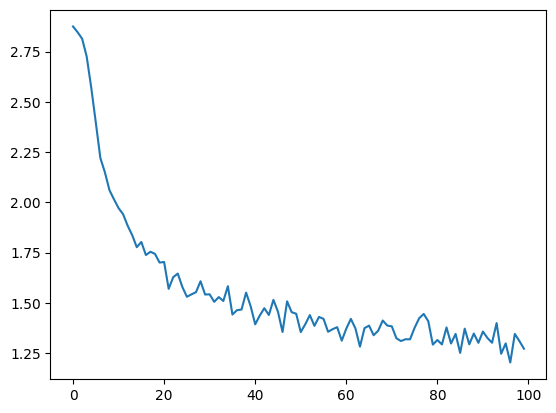

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-63-85bc14ac3fe9>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-63-85bc14ac3fe9>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


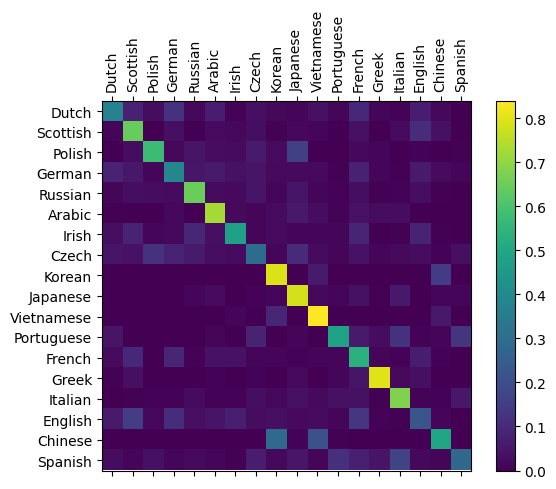

In [ ]:
# row (actual) / column (guess)
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
  hidden = rnn.initHidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  return output

for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
  print('\n> %s' % input_line)
  with torch.no_grad():
    output = evaluate(lineToTensor(input_line))

    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print("(%.2f) %s" % (value, all_categories[category_index]))
      predictions.append([value, all_categories[category_index]])

In [ ]:
predict('Ban')


> Ban
(-0.88) Chinese
(-0.93) Vietnamese
(-3.00) Irish
